In [ ]:
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM, Conv1D, MaxPooling1D
from keras.utils import to_categorical

from google.colab import drive

drive.mount("/content/drive", force_remount=True)

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.random.set_seed(3)

# 학습셋과 테스트셋 지정하기
# section [0 : 정치, 1 : 경제, 2 : 사회, 3 : IT과학]
train_data = pd.read_csv("/content/drive/MyDrive/AI/week12/data/train_SectionDataset.csv", header=0, names=['title', 'section'])
x_train = train_data['title']
y_train = train_data['section']

test_data = pd.read_csv("/content/drive/MyDrive/AI/week12/data/test_SectionDataset.csv", header=0, names=['title', 'section'])
x_test = test_data['title']
y_test = test_data['section']

# 데이터 확인하기
print("첫번째 학습셋 입력:", x_train[0])
print("첫번째 테스트셋 입력:", x_test[0])
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
print("첫번째 학습셋 결과 one-hot 출력:", y_train_onehot[0])
print("첫번째 테스트셋 결과 one-hot 출력:", y_test_onehot[0])

# 토큰화
token = Tokenizer()
token.fit_on_texts(x_train)
x_train_sequence = token.texts_to_sequences(x_train) # 2차원 배열
x_test_sequence = token.texts_to_sequences(x_test) # 2차원 배열


Mounted at /content/drive
첫번째 학습셋 입력: 유시민 검찰도 사법도 썩었지 vs 진중권 유시민 망상 대중은 현실로 믿어
첫번째 테스트셋 입력: 박준영 “도자기 집에서 사용” 김선교 “궁궐 살았나”
첫번째 학습셋 결과 one-hot 출력: [1. 0. 0. 0.]
첫번째 테스트셋 결과 one-hot 출력: [1. 0. 0. 0.]


In [ ]:
# 최대 길이 구하기
max_len_train = max(len(l) for l in x_train_sequence)
print("학습셋 제목 최대 길이 :", max_len_train)

max_len_test = max(len(l) for l in x_test_sequence)
print("테스트셋 제목 최대 길이 :", max_len_test)

# 임베딩에 입력될 단어 수 지정
word_size = len(token.word_index) + 1
print("전체 데이터셋 단어 토큰 개수:", word_size)

print("첫번째 학습셋 토큰 결과:", x_train_sequence[0])
print("첫번째 테스트셋 토큰 결과:", x_test_sequence[0])

# 패딩, 서로 다른 길이의 데이터를 max_len로 맞춤
max_len = max(max_len_train, max_len_test)
padded_x_train = pad_sequences(x_train_sequence, max_len)
padded_x_test = pad_sequences(x_test_sequence, max_len)
print("첫번째 학습셋 패팅 토큰:", padded_x_train[0])
print("첫번째 테스트셋 패팅 토큰:", padded_x_test[0])

학습셋 제목 최대 길이 : 18
테스트셋 제목 최대 길이 : 10
전체 데이터셋 단어 토큰 개수: 22844
첫번째 학습셋 토큰 결과: [238, 7160, 7161, 7162, 122, 404, 238, 7163, 7164, 4269, 4270]
첫번째 테스트셋 토큰 결과: [1200]
첫번째 학습셋 패팅 토큰: [   0    0    0    0    0    0    0  238 7160 7161 7162  122  404  238
 7163 7164 4269 4270]
첫번째 테스트셋 패팅 토큰: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1200]


In [28]:
# 모델의 설정
model = Sequential()
model.add(Embedding(word_size, 100, input_length=max_len))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(1))
model.add(Dense(4, activation='softmax'))
model.summary()

# 모델의 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델의 실행
history = model.fit(padded_x_train, y_train_onehot, epochs=20, validation_data=(padded_x_test, y_test_onehot))
print("\n Test Accuracy: %.4f" % (model.evaluate(padded_x_test, y_test_onehot)[1]))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 18, 100)           2284400   
                                                                 
 dropout_3 (Dropout)         (None, 18, 100)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 64)            32064     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                      

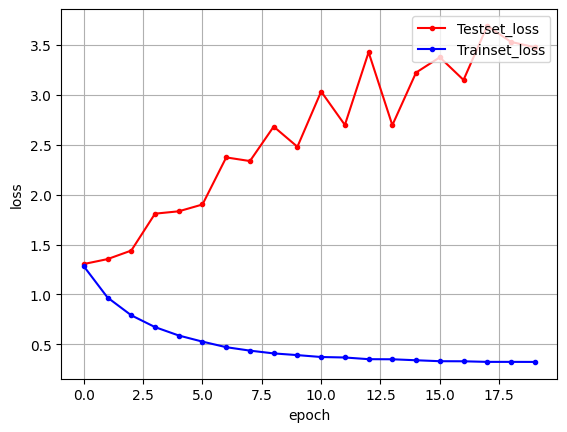

In [30]:
# 테스트셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker=".", c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker=".", c="blue", label="Trainset_loss")

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc="upper right")
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
prediction = model.predict(padded_x_test)
for i in range(3):
  expect = numpy.argmax(prediction[i], -1)
  print("Index:", i, "실제 문장:", x_test[i])
  print("padded sequence:", padded_x_test[0])
  print("예측 결과:", prediction[i])
  print("Actual Section:", y_test[i], ", Expected Section:", expect)
  print()

6/6 [==============================] - 0s 3ms/step
Index: 0 실제 문장: 박준영 “도자기 집에서 사용” 김선교 “궁궐 살았나”
padded sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1200]
예측 결과: [0.03231588 0.23351994 0.7319255  0.00223874]
Actual Section: 0 , Expected Section: 2

Index: 1 실제 문장: 박준영 아내 도자기 의혹 사과...카페 운영 중단
padded sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1200]
예측 결과: [7.2749607e-02 7.2588483e-03 9.1995573e-01 3.5812402e-05]
Actual Section: 0 , Expected Section: 2

Index: 2 실제 문장: 배우자 도자기 의혹 박준영 해당 카페 운영 않을 계획
padded sequence: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1200]
예측 결과: [2.4726930e-08 9.0486676e-01 4.5777824e-06 9.5128678e-02]
Actual Section: 0 , Expected Section: 1

